In [37]:
print("start")

start


In [38]:
# clear modules
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import sys
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # silence warning logs
singularity_name = os.environ.get("SINGULARITY_NAME")
if singularity_name: print("Singularity:\t", singularity_name)    
print("version_info:\t", sys.version_info)
print("executable:\t",sys.executable)
print("pwd:\t\t", os.getcwd())

Singularity:	 TensorFlow:25.02-tf2-py3.SIF
version_info:	 sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
executable:	 /usr/bin/python
pwd:		 /auto/brno2/home/romova9


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import ndnoise
import random
from numbers import Number
from typing import Optional
from pathlib import Path
import scipy
import cv2
import skimage.transform
import nibabel
import h5py
import json

from PIL import Image
from loguru import logger
import io3d
import io3d.datasets
logger.enable("io3d")
logger.disable("io3d")

#from skimage.filters import threshold_otsu
#from scipy.ndimage import gaussian_filter
#from scipy.ndimage import zoom

def window(
    data3d: np.ndarray,
    vmin: Optional[Number] = None,
    vmax: Optional[Number] = None,
    center: Optional[Number] = None,
    width: Optional[Number] = None,
    vmin_out: Optional[Number] = 0,
    vmax_out: Optional[Number] = 255,
    dtype=np.uint8,
):
    """
    Rescale input ndarray and trim the outlayers. Used for image intensity windowing.
    :param data3d: ndarray with numbers
    :param vmin: minimal input value. Skipped if center and width is given.
    :param vmax: maximal input value. Skipped if center and width is given.
    :param center: Window center
    :param width: Window width
    :param vmin_out: Output mapping minimal value
    :param vmax_out: Output mapping maximal value
    :param dtype: Output dtype
    :return:
    """
    if width and center:
        vmin = center - (width / 2.0)
        vmax = center + (width / 2.0)

    # logger.debug(f"vmin={vmin}, vmax={vmax}")
    k = float(vmax_out - vmin_out) / (vmax - vmin)
    q = vmax_out - k * vmax
    # logger.debug(f"k={k}, q={q}")
    data3d_out = data3d * k + q

    data3d_out[data3d_out > vmax_out] = vmax_out
    data3d_out[data3d_out < vmin_out] = vmin_out

    return data3d_out.astype(dtype)

def preprocess(imgs, is_mask=False, img_rows=256, img_cols=256):
    if not is_mask:
        imgs = window(imgs, center=40, width=400, vmin_out=0, vmax_out=255, dtype=np.uint8)

    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = skimage.transform.resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    if is_mask:
        imgs_p = (imgs_p > 0).astype('float32')
    else:
        imgs_p = imgs_p.astype('float32') / 255.
    return imgs_p

def noisegenerator(shape):
    noise = ndnoise.generator.noises(
        shape,
        sample_spacing=[1,1,1],
        #random_generator_seed=5,
        lambda0=1,  # nastavení hrubeho sumu v pixelech
        lambda1=16, # vzdálenost shluků (rozptyl?)
        exponent=0, # prudkost rozdílu v
        method="space"
    )
    noise = (noise+abs(np.min(noise))) # na kladne hodnoty
    noise = noise/np.max(noise) # rozptyl 0-1
    return np.array(noise)

def noisegenerator_standart(shape):
    data0 = np.random.random(shape)  # or however you generate your noise
    # Ensure sigma is a sequence of length equal to the input rank (number of dimensions)
    sigma = [1] * len(data0.shape)  # create a sequence with length equal to the number of dimensions of data0
    noise = scipy.ndimage.gaussian_filter(data0, sigma=sigma)
    return noise

In [41]:
def load_nii_as_numpy(file_path):
    """Load a NIfTI (.nii.gz) file as a NumPy array."""
    nii_img = nibabel.load(file_path)  # Load the NIfTI image
    data = nii_img.get_fdata()  # Get the image data as a NumPy array
    return data

def split_files(files, train_ratio=0.8):
    """Randomly split files into training and validation sets based on the given ratio."""
    random.shuffle(files)
    split_index = int(len(files) * train_ratio)
    train_files = files[:split_index]
    val_files = files[split_index:]
    return train_files, val_files


def image_generator_deepvesselnet(ct_ids, batch_size, shape=(128, 256, 256)):
    """Deepvesselnet"""
    while True:
        dataset = '2D_to_3D/data/deepvesselnet'
        batch_data_raw = []
        batch_data_mask = []
        
        for _ in range(batch_size):
            # Randomly choose a CT scan ID.
            ct_id = ct_ids[np.random.choice(range(len(ct_ids)), size=1)[0]]
            
            # Load CT data.
            raw_p = load_nii_as_numpy(dataset + '/raw/' + ct_id)  
            dataRaw = window(raw_p, center=40, width=400)
            
            # Determine cropping coordinates.
            # If the data is smaller than the desired shape, we set the offset to 0.
            x_max = max(dataRaw.shape[0] - shape[0], 0)
            y_max = max(dataRaw.shape[1] - shape[1], 0)
            z_max = max(dataRaw.shape[2] - shape[2], 0)
            xscale = random.randrange(0, x_max + 1)  # +1 to include endpoint
            yscale = random.randrange(0, y_max + 1)
            zscale = random.randrange(0, z_max + 1)
            
            # Crop raw data.
            cropped_dataRaw = dataRaw[xscale:xscale + shape[0],
                                      yscale:yscale + shape[1],
                                      zscale:zscale + shape[2]]
           
            # Process and combine mask data from multiple parameters.
            mask_data = load_nii_as_numpy(dataset + '/seg/' + ct_id)*255

            # Crop the mask using the same coordinates.
            mask_data = mask_data[xscale:xscale + shape[0], yscale:yscale + shape[1], zscale:zscale + shape[2]]
            # Threshold to obtain a binary mask.
            mask_data = (mask_data > 0.5).astype(np.float32)
            background = 1 - mask_data
            # Create an array with shape (x, y, z, 2) for background and foreground.
            dataMask = np.zeros(mask_data.shape + (2,), dtype=np.float32)
            dataMask[..., 0] = mask_data  # Channel 0: foreground
            dataMask[..., 1] = background   # Channel 1: background
            
            # Optionally apply noise.
            if random.randint(0, 1) > 0:
                cropped_dataRaw = (cropped_dataRaw + noisegenerator(cropped_dataRaw.shape)) / 2
                
            # Process raw data: add channel dimension and replicate to form 3 channels.
            cropped_dataRaw = np.expand_dims(cropped_dataRaw, axis=-1)  # (x,y,z,1)
            #cropped_dataRaw = np.concatenate([cropped_dataRaw] * 3, axis=-1)  # (x,y,z,3)
            cropped_dataRaw = np.clip(cropped_dataRaw, 0, 255).astype(np.float32) / 255.0
            
            # Append processed sample to the batch.
            batch_data_raw.append(cropped_dataRaw)
            batch_data_mask.append(dataMask)
            
            #print(np.min(cropped_dataRaw), np.max(cropped_dataRaw), len(np.unique(cropped_dataRaw)))
            #print(np.min(mask_data), np.max(mask_data), len(np.unique(mask_data)))
            #print(np.min(background), np.max(background), len(np.unique(background)))
            #print()
                
        # Convert lists to numpy arrays.
        batch_data_raw = np.array(batch_data_raw, dtype=np.float32)
        batch_data_mask = np.array(batch_data_mask, dtype=np.float32)
        
        if batch_data_raw.shape[1:4] != shape:
                batch_data_raw = np.resize(batch_data_raw, (batch_size, shape[0], shape[1], shape[2], 3))
        if batch_data_mask.shape[1:4] != shape:
            batch_data_mask = np.resize(batch_data_mask, (batch_size, shape[0], shape[1], shape[2], 2))
               
        yield batch_data_raw, batch_data_mask

In [42]:
def image_generator(ct_ids, promenne, batch_size, shape=(128, 256, 256)):
    """
    Generator that yields batches of CT data and corresponding segmentation masks. -> 3x ten samy kanal
    
    The output masks have shape (batch_size, x, y, z, num_classes), where num_classes=2:
      - Channel 0 is background.
      - Channel 1 is foreground.
    
    Parameters:
      ct_ids    : List of CT scan IDs.
      promenne  : List of dataset names (first element is ignored).
      batch_size: Number of samples per batch.
      shape     : Target crop shape (x, y, z).
    """
    # Skip the first element if it is not used.
    promenne = np.array(promenne[1:])
    new_voxelsize_mm = [1, 1, 1]
    
    while True:
        batch_data_raw = []
        batch_data_mask = []
        
        for _ in range(batch_size):
            # Randomly choose a CT scan ID.
            ct_id = np.random.choice(ct_ids)
            
            # Load CT data.
            dataset_path = io3d.datasets.get_dataset_path("3Dircadb1", "data3d", ct_id)
            raw_p = io3d.read(dataset_path)
            dataRaw = window(raw_p.data3d, center=40, width=400)
            dataRaw = io3d.image_manipulation.resize_to_mm(
                dataRaw,
                voxelsize_mm=raw_p.voxelsize_mm,
                new_voxelsize_mm=new_voxelsize_mm
            )
            #print(dataRaw.shape)
            
            # Determine cropping coordinates.
            # If the data is smaller than the desired shape, we set the offset to 0.
            x_max = max(dataRaw.shape[0] - shape[0], 0)
            y_max = max(dataRaw.shape[1] - shape[1], 0)
            z_max = max(dataRaw.shape[2] - shape[2], 0)
            xscale = random.randrange(0, x_max + 1)  # +1 to include endpoint
            yscale = random.randrange(0, y_max + 1)
            zscale = random.randrange(0, z_max + 1)
            
            # Crop raw data.
            cropped_dataRaw = dataRaw[xscale:xscale + shape[0],
                                      yscale:yscale + shape[1],
                                      zscale:zscale + shape[2]]
           
            # Process and combine mask data from multiple parameters.
            mask_data = np.zeros(shape)
            for param in promenne:
                mask_datal = io3d.read_dataset("3Dircadb1", param, ct_id).data3d
                mask_datal = io3d.image_manipulation.resize_to_mm(
                    mask_datal,
                    voxelsize_mm=raw_p.voxelsize_mm,
                    new_voxelsize_mm=new_voxelsize_mm
                )
                # Crop the mask using the same coordinates.
                mask_datal = mask_datal[xscale:xscale + shape[0],
                                         yscale:yscale + shape[1],
                                         zscale:zscale + shape[2]]
                # Threshold to obtain a binary mask.
                mask_data = mask_datal + mask_data
                
            mask_data = (mask_data > 0.5).astype(np.float32)
            background = 1 - mask_data
            # Create an array with shape (x, y, z, 2) for background and foreground.
            dataMask = np.zeros(mask_data.shape + (2,), dtype=np.float32)
            dataMask[..., 0] = mask_data  # Channel 0: foreground
            dataMask[..., 1] = background   # Channel 1: background
            
            # Optionally apply noise.
            if random.randint(0, 1) > 0:
                cropped_dataRaw = (cropped_dataRaw + noisegenerator(cropped_dataRaw.shape)) / 2
                
            # Process raw data: add channel dimension and replicate to form 3 channels.
            cropped_dataRaw = np.expand_dims(cropped_dataRaw, axis=-1)  # (x,y,z,1)
            #cropped_dataRaw = np.concatenate([cropped_dataRaw] * 3, axis=-1)  # (x,y,z,3)
            cropped_dataRaw = np.clip(cropped_dataRaw, 0, 255).astype(np.float32) / 255.0
            
            # Append processed sample to the batch.
            batch_data_raw.append(cropped_dataRaw)
            batch_data_mask.append(dataMask)
                
        # Convert lists to numpy arrays.
        batch_data_raw = np.array(batch_data_raw, dtype=np.float32)
        batch_data_mask = np.array(batch_data_mask, dtype=np.float32)
        
        if batch_data_raw.shape[1:4] != shape:
                batch_data_raw = np.resize(batch_data_raw, (batch_size, shape[0], shape[1], shape[2], 3))
        if batch_data_mask.shape[1:4] != shape:
            batch_data_mask = np.resize(batch_data_mask, (batch_size, shape[0], shape[1], shape[2], 2))
               
        yield batch_data_raw, batch_data_mask

In [43]:
import nibabel as nib
import scipy.ndimage
import numpy as np
import random

def resample_to_voxelsize(img_np, original_spacing, target_spacing=(1.0, 1.0, 1.0), order=3):
    zoom_factors = [o / t for o, t in zip(original_spacing, target_spacing)]
    return scipy.ndimage.zoom(img_np, zoom_factors, order=order)

def image_generator_pilsen_pigs(ct_ids, batch_size, shape=(128, 256, 256)):
    """Pilsen Pigs generator with voxel size resampling."""
    while True:
        dataset = '2D_to_3D/data/pilsen_pigs'
        batch_data_raw = []
        batch_data_mask = []

        ct_id = ct_ids[np.random.choice(len(ct_ids))]

        # Load NIfTI using nibabel to access voxel spacing
        raw_nii = nib.load(f'{dataset}/{ct_id}/{ct_id}.nii.gz')
        raw = raw_nii.get_fdata()
        spacing = raw_nii.header.get_zooms()[:3]  # (z, y, x)

        raw = window(raw, center=40, width=400)

        # Load mask
        mask_nii = nib.load(f'{dataset}/{ct_id}/artery.nii.gz')
        mask = mask_nii.get_fdata()
        mask = (mask > 0.5).astype(np.float32)

        # Resample to isotropic 1x1x1 mm
        raw = resample_to_voxelsize(raw, spacing, target_spacing=(1.0, 1.0, 1.0), order=3)
        mask = resample_to_voxelsize(mask, spacing, target_spacing=(1.0, 1.0, 1.0), order=0)

        for _ in range(batch_size):
            pad_shape = np.maximum(shape, raw.shape)
            pad_x = pad_shape[0] - raw.shape[0]
            pad_y = pad_shape[1] - raw.shape[1]
            pad_z = pad_shape[2] - raw.shape[2]

            padded_raw = np.pad(raw, ((0, pad_x), (0, pad_y), (0, pad_z)), mode='constant')
            padded_mask = np.pad(mask, ((0, pad_x), (0, pad_y), (0, pad_z)), mode='constant')

            # Crop
            xscale = random.randint(0, padded_raw.shape[0] - shape[0])
            yscale = random.randint(0, padded_raw.shape[1] - shape[1])
            zscale = random.randint(0, padded_raw.shape[2] - shape[2])

            cropped_raw = padded_raw[xscale:xscale + shape[0],
                                     yscale:yscale + shape[1],
                                     zscale:zscale + shape[2]]

            cropped_mask = padded_mask[xscale:xscale + shape[0],
                                       yscale:yscale + shape[1],
                                       zscale:zscale + shape[2]]

            # Final mask with background channel
            background = 1.0 - cropped_mask
            dataMask = np.stack([cropped_mask, background], axis=-1)

            if random.randint(0, 1):
                cropped_raw = (cropped_raw + noisegenerator(cropped_raw.shape)) / 2

            # Normalize and prepare for input
            cropped_raw = np.expand_dims(cropped_raw, axis=-1)
            #cropped_raw = np.repeat(cropped_raw, 3, axis=-1)
            cropped_raw = cropped_raw.astype(np.float32) / np.max(cropped_raw)

            batch_data_raw.append(cropped_raw)
            batch_data_mask.append(dataMask)

        batch_data_raw = np.stack(batch_data_raw, axis=0).astype(np.float32)
        batch_data_mask = np.stack(batch_data_mask, axis=0).astype(np.float32)

        yield np.array(batch_data_raw), np.array(batch_data_mask)



In [44]:
def visualize_batch(batch_x, batch_y, slice_=50):
    """Visualize a batch of 3D images."""
    batch_size = batch_x.shape[0]
    slice_x = slice_
    slice_y = slice_
    slice_z = slice_
    
    # Plot 3 slices from the batch
    fig, axes = plt.subplots(batch_size, 3, figsize=(12, 4 * batch_size))

    for i in range(batch_size):
        print("batch_x: ", batch_x[i].shape, np.min(batch_x), np.max(batch_x))
        # Show first slice of each dimension
        axes[i, 0].imshow(batch_x[i][slice_x, :, :, 0], cmap="gray")  # First slice of the depth (z)
        axes[i, 0].set_title(f"Raw Image {i+1} - Slice X - Axial")

        axes[i, 1].imshow(batch_x[i][:, slice_y, :, 0], cmap="gray")  # Middle slice of the depth (y)
        axes[i, 1].set_title(f"Raw Image {i+1} - Slice Y - Coronal")

        axes[i, 2].imshow(batch_x[i][:, :, slice_z, 0], cmap="gray")  # Middle slice of the depth (x)
        axes[i, 2].set_title(f"Raw Image {i+1} - Slice Z - Sagital")
        
    plt.show()
    
    # Plot 3 slices from the batch
    fig, axes = plt.subplots(batch_size, 3, figsize=(12, 4 * batch_size))

    for i in range(batch_size):
        print( "batch_y: ", batch_y[i].shape, np.min(batch_y), np.max(batch_y))
        # Show first slice of each dimension
        axes[i, 0].imshow(batch_y[i][slice_x, :, :,0], cmap="gray")  # First slice of the depth (z)
        axes[i, 0].set_title(f"Raw Image {i+1} - Slice X")

        axes[i, 1].imshow(batch_y[i][:,slice_y , :, 0], cmap="gray")  # Middle slice of the depth (y)
        axes[i, 1].set_title(f"Raw Image {i+1} - Slice Y")

        axes[i, 2].imshow(batch_y[i][:, :,slice_z, 0], cmap="gray")  # Middle slice of the depth (x)
        axes[i, 2].set_title(f"Raw Image {i+1} - Slice Z")
        
    plt.show()
    
    # Plot 3 slices from the batch
    fig, axes = plt.subplots(batch_size, 3, figsize=(12, 4 * batch_size))

    for i in range(batch_size):
        # Show first slice of each dimension
        axes[i, 0].imshow(batch_y[i][slice_x, :, :, 1], cmap="gray")  # First slice of the depth (z)
        axes[i, 0].set_title(f"Raw Image {i+1} - Slice X")

        axes[i, 1].imshow(batch_y[i][:, slice_y, :, 1], cmap="gray")  # Middle slice of the depth (y)
        axes[i, 1].set_title(f"Raw Image {i+1} - Slice Y")

        axes[i, 2].imshow(batch_y[i][:, :, slice_z, 1], cmap="gray")  # Middle slice of the depth (x)
        axes[i, 2].set_title(f"Raw Image {i+1} - Slice Z")
        
    plt.show()
    
def visualize_batch_contur(batch_x, batch_y, slice_x=50, slice_y=50, slice_z=50, alpha=0.5):
    """Visualize a batch of 3D images with label contours over raw data."""
    batch_size = batch_x.shape[0]
    
    fig, axes = plt.subplots(batch_size, 3, figsize=(12, 4 * batch_size))

    for i in range(batch_size):
        # Slice X (Axial)
        img = batch_x[i][slice_x, :, :, 0]
        lbl = batch_y[i][slice_x, :, :, 0]
        axes[i, 0].imshow(img, cmap="gray")
        axes[i, 0].contour(lbl, colors='r', linewidths=1)
        axes[i, 0].set_title(f"Sample {i+1} - Slice X (Axial)")

        # Slice Y (Coronal)
        img = batch_x[i][:, slice_y, :, 0]
        lbl = batch_y[i][:, slice_y, :, 0]
        axes[i, 1].imshow(img, cmap="gray")
        axes[i, 1].contour(lbl, colors='r', linewidths=1)
        axes[i, 1].set_title(f"Sample {i+1} - Slice Y (Coronal)")

        # Slice Z (Sagittal)
        img = batch_x[i][:, :, slice_z, 0]
        lbl = batch_y[i][:, :, slice_z, 0]
        axes[i, 2].imshow(img, cmap="gray")
        axes[i, 2].contour(lbl, colors='r', linewidths=1)
        axes[i, 2].set_title(f"Sample {i+1} - Slice Z (Sagittal)")

    plt.tight_layout()
    plt.show()


# Data

In [45]:
io3d.datasets.DATASET_PATH_STRUCTURE["3Dircadb1"]["_"] = "medical/orig/3Dircadb1/3Dircadb1.{id}/MASKS_DICOM/{data_type}/"
io3d.datasets.DATASET_PATH_STRUCTURE["3Dircadb1"]["data3d"] = "medical/orig/3Dircadb1/3Dircadb1.{id}/PATIENT_DICOM/"
io3d.datasets.get_dataset_path("3Dircadb1", "data3d", 1)

PosixPath('/storage/brno2/home/romova9/data/medical/orig/3Dircadb1/3Dircadb1.1/PATIENT_DICOM')

In [46]:
#     DICOM_file - NEW_voxelsize = [1,1,1]        ORIG_data_shape      ORIG_data_voxelsize   RESIZED_data_shape
# ----------------------------------------------------------------------------------------------------------------------------------
portalvein =      [1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]     # portalvein - zdola do jater
artery =          [1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 17] 
venacava =        [2, 11, 12, 13, 18]                                      # venacava - shora do jater
venoussystem =    [1, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 19]
cevy =            [1, 4, 5, 6, 7, 8, 9, 17]      # artery, portalvein, venoussystem
cevy1 =           [1, 4, 5, 6, 7, 8, 9, 14, 15, 16, 17, 19]   # portalvein, venoussystem
liver =           [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

s_artery = ['artery','artery'] # format [jmeno_modelu, slozky ...]
s_portalvein = ['portalvein', 'portalvein']
s_venacava = ['venacava', 'venacava']
s_venoussystem = ['venoussystem', 'venoussystem']
s_cevy = ['cevy', 'artery','portalvein','venoussystem']
s_cevy1 = ['cevy1', 'portalvein','venoussystem']
s_liver = ['liver', 'liver']

In [47]:
'''
ct_ids_train = [1, 2, 4, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19] 
ct_ids_test = [6,5]
promene = s_portalvein

ct_ids_train = [1, 4, 7, 8, 9, 14, 15, 16, 17, 19]
ct_ids_test = [6,5]
promene = s_venoussystem

ct_ids_train = [1, 4, 6, 7, 8, 9, 14, 15, 16, 19] 
ct_ids_test = [17,5]
promene = s_cevy1

ct_ids_train = [1,2,3,4,6,7,8,9,11,12,13,14,15,16,18,19,20]
ct_ids_test = [17,10,5]
promene = s_liver
'''

'\nct_ids_train = [1, 2, 4, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19] \nct_ids_test = [6,5]\npromene = s_portalvein\n\nct_ids_train = [1, 4, 7, 8, 9, 14, 15, 16, 17, 19]\nct_ids_test = [6,5]\npromene = s_venoussystem\n\nct_ids_train = [1, 4, 6, 7, 8, 9, 14, 15, 16, 19] \nct_ids_test = [17,5]\npromene = s_cevy1\n\nct_ids_train = [1,2,3,4,6,7,8,9,11,12,13,14,15,16,18,19,20]\nct_ids_test = [17,10,5]\npromene = s_liver\n'

In [48]:
'''directory = "2D_to_3D/data/pilsen_pigs"  # 'data/deepvesselnet/seg'   # "data/pilsen_pigs"

all_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

all_dirs = [d for d in all_dirs if d.startswith("Tx")]

ct_ids_train, ct_ids_test = split_files(all_dirs, train_ratio=0.8)
'''

'directory = "2D_to_3D/data/pilsen_pigs"  # \'data/deepvesselnet/seg\'   # "data/pilsen_pigs"\n\nall_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]\nall_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]\n\nall_dirs = [d for d in all_dirs if d.startswith("Tx")]\n\nct_ids_train, ct_ids_test = split_files(all_dirs, train_ratio=0.8)\n'

In [49]:
def data_generator(task, batch_size, shape):
    ct_ids_train = []
    ct_ids_test = []
    
    if (task == 'ircad'):
        ct_ids_train = [1,2,3,4,6,7,8,9,11,12,13,14,15,16,18,19,20]
        ct_ids_test = [17,10,5]
        promene = s_liver
        train_generator = image_generator(ct_ids_train, promene, batch_size=batch_size, shape=shape)
        test_generator  = image_generator(ct_ids_test, promene, batch_size=batch_size, shape=shape)
        text = promene[0]
        
    elif (task == 'pisen_pigs'):
        ct_ids_train = ['Tx025D_Art', 'Tx017D_Art', 'Tx019D_Ven', 'Tx038D_Art', 'Tx025D_Ven', 'Tx039D_Art', 'Tx041D_Art', 'Tx023D_Ven', 'Tx031D_Art', 'Tx024D_Art', 'Tx030D_Art', 'Tx037D_Art', 'Tx018D_Art']
        ct_ids_test = ['Tx021D_Ven', 'Tx040D_Art']     
        train_generator = image_generator_pilsen_pigs(ct_ids_train, batch_size=batch_size, shape=shape)
        test_generator  = image_generator_pilsen_pigs(ct_ids_test, batch_size=batch_size, shape=shape)
        text = task
        
    elif (task == 'deepvesselnet'):
        directory = "2D_to_3D/data/deepvesselnet/raw"
        all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]    
        ct_ids_train, ct_ids_test = split_files(all_files, train_ratio=0.8)
        train_generator = image_generator_deepvesselnet(ct_ids_train, batch_size=batch_size, shape=shape)
        test_generator  = image_generator_deepvesselnet(ct_ids_test, batch_size=batch_size, shape=shape)
        text = task
        
    else: print("Nebyla zadana uloha")
    
    # Calculate steps per epoch
    train_steps = (len(ct_ids_train) * batch_size) // batch_size
    test_steps = (len(ct_ids_test) * batch_size) // batch_size
    
    print("ct_ids_train: ", ct_ids_train)
    print()
    print("ct_ids_test: ", ct_ids_test)
    print()

    return train_generator, test_generator, train_steps, test_steps

In [15]:
task = 'pisen_pigs' #ircad, deepvesselnet, pisen_pigs
batch_size=10
shape=(256,256,128)


train_generator, test_generator, train_steps, test_steps = data_generator(task=task, batch_size=batch_size, shape=shape)

batch_x, batch_y = next(train_generator)

ct_ids_train:  ['Tx025D_Art', 'Tx017D_Art', 'Tx019D_Ven', 'Tx038D_Art', 'Tx025D_Ven', 'Tx039D_Art', 'Tx041D_Art', 'Tx023D_Ven', 'Tx031D_Art', 'Tx024D_Art', 'Tx030D_Art', 'Tx037D_Art', 'Tx018D_Art']

ct_ids_test:  ['Tx021D_Ven', 'Tx040D_Art']



batch_x:  (256, 256, 128, 1) 0.0 1.0
batch_x:  (256, 256, 128, 1) 0.0 1.0
batch_x:  (256, 256, 128, 1) 0.0 1.0
batch_x:  (256, 256, 128, 1) 0.0 1.0
batch_x:  (256, 256, 128, 1) 0.0 1.0
batch_x:  (256, 256, 128, 1) 0.0 1.0
batch_x:  (256, 256, 128, 1) 0.0 1.0
batch_x:  (256, 256, 128, 1) 0.0 1.0
batch_x:  (256, 256, 128, 1) 0.0 1.0
batch_x:  (256, 256, 128, 1) 0.0 1.0


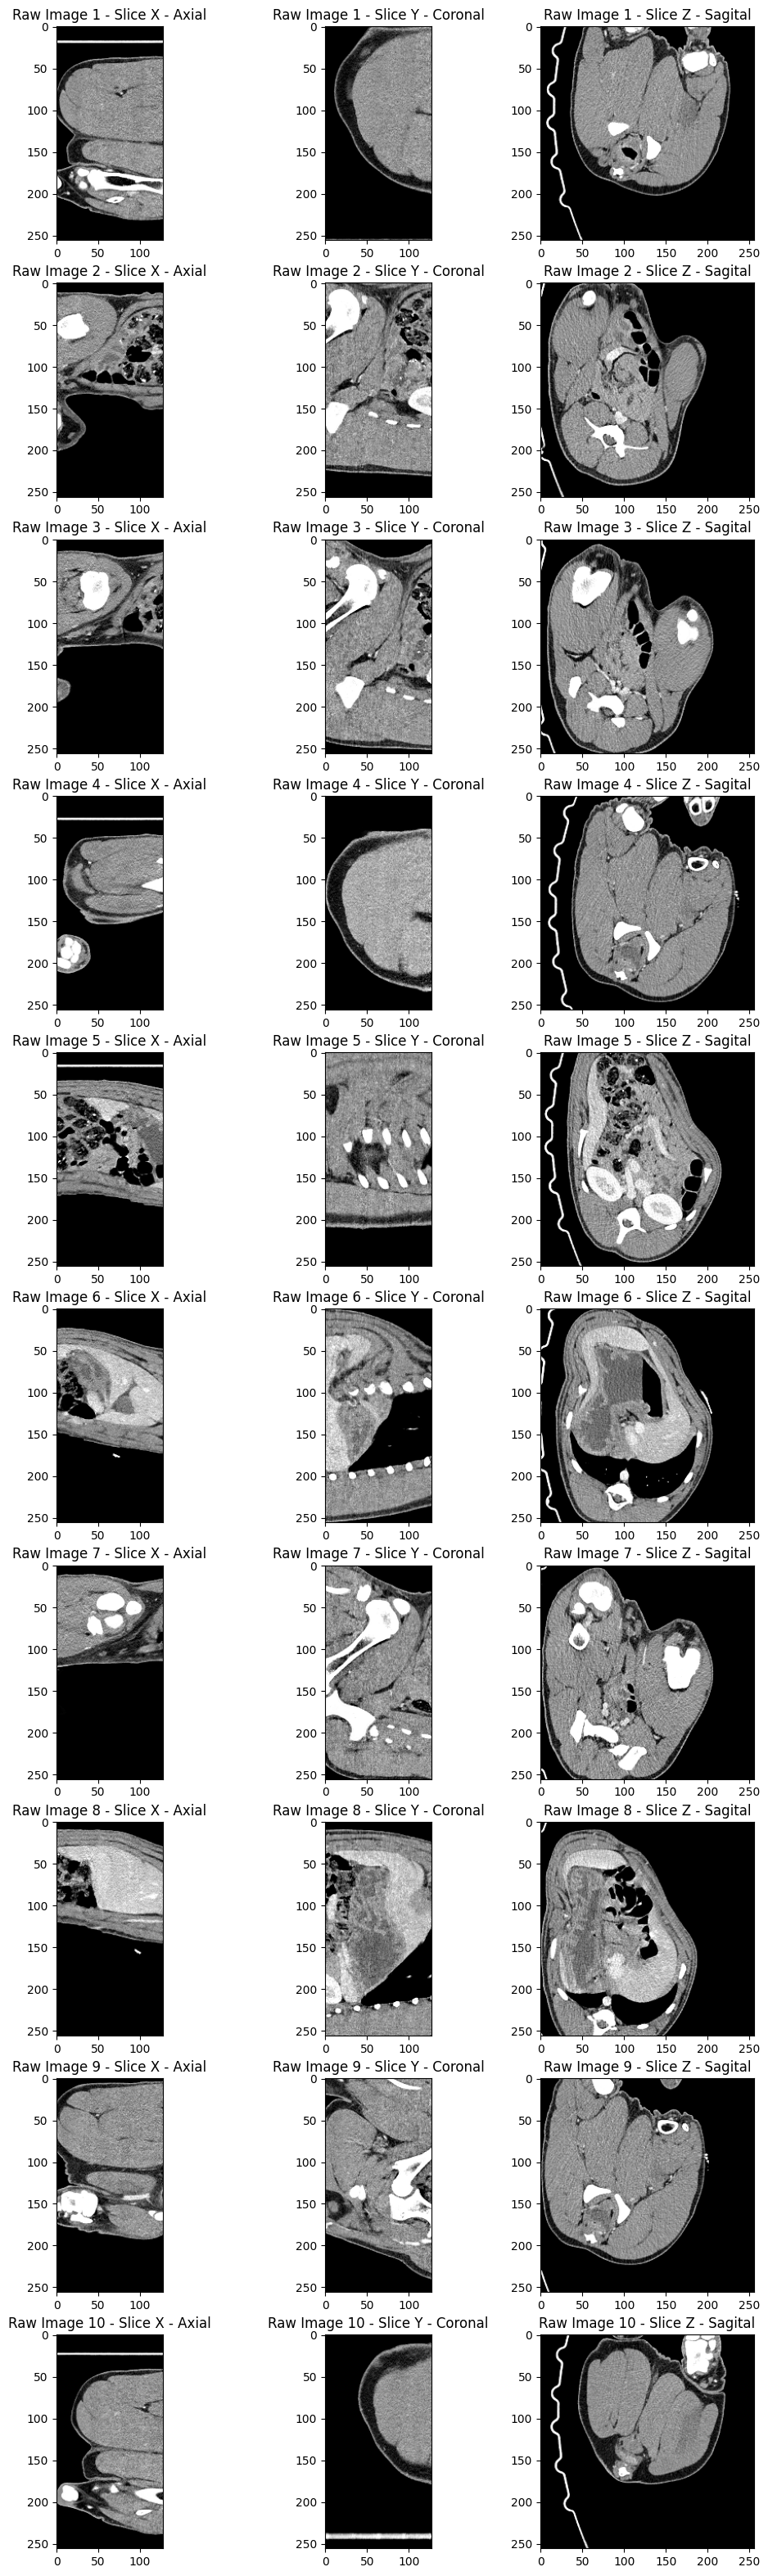

batch_y:  (256, 256, 128, 2) 0.0 1.0
batch_y:  (256, 256, 128, 2) 0.0 1.0
batch_y:  (256, 256, 128, 2) 0.0 1.0
batch_y:  (256, 256, 128, 2) 0.0 1.0
batch_y:  (256, 256, 128, 2) 0.0 1.0
batch_y:  (256, 256, 128, 2) 0.0 1.0
batch_y:  (256, 256, 128, 2) 0.0 1.0
batch_y:  (256, 256, 128, 2) 0.0 1.0
batch_y:  (256, 256, 128, 2) 0.0 1.0
batch_y:  (256, 256, 128, 2) 0.0 1.0


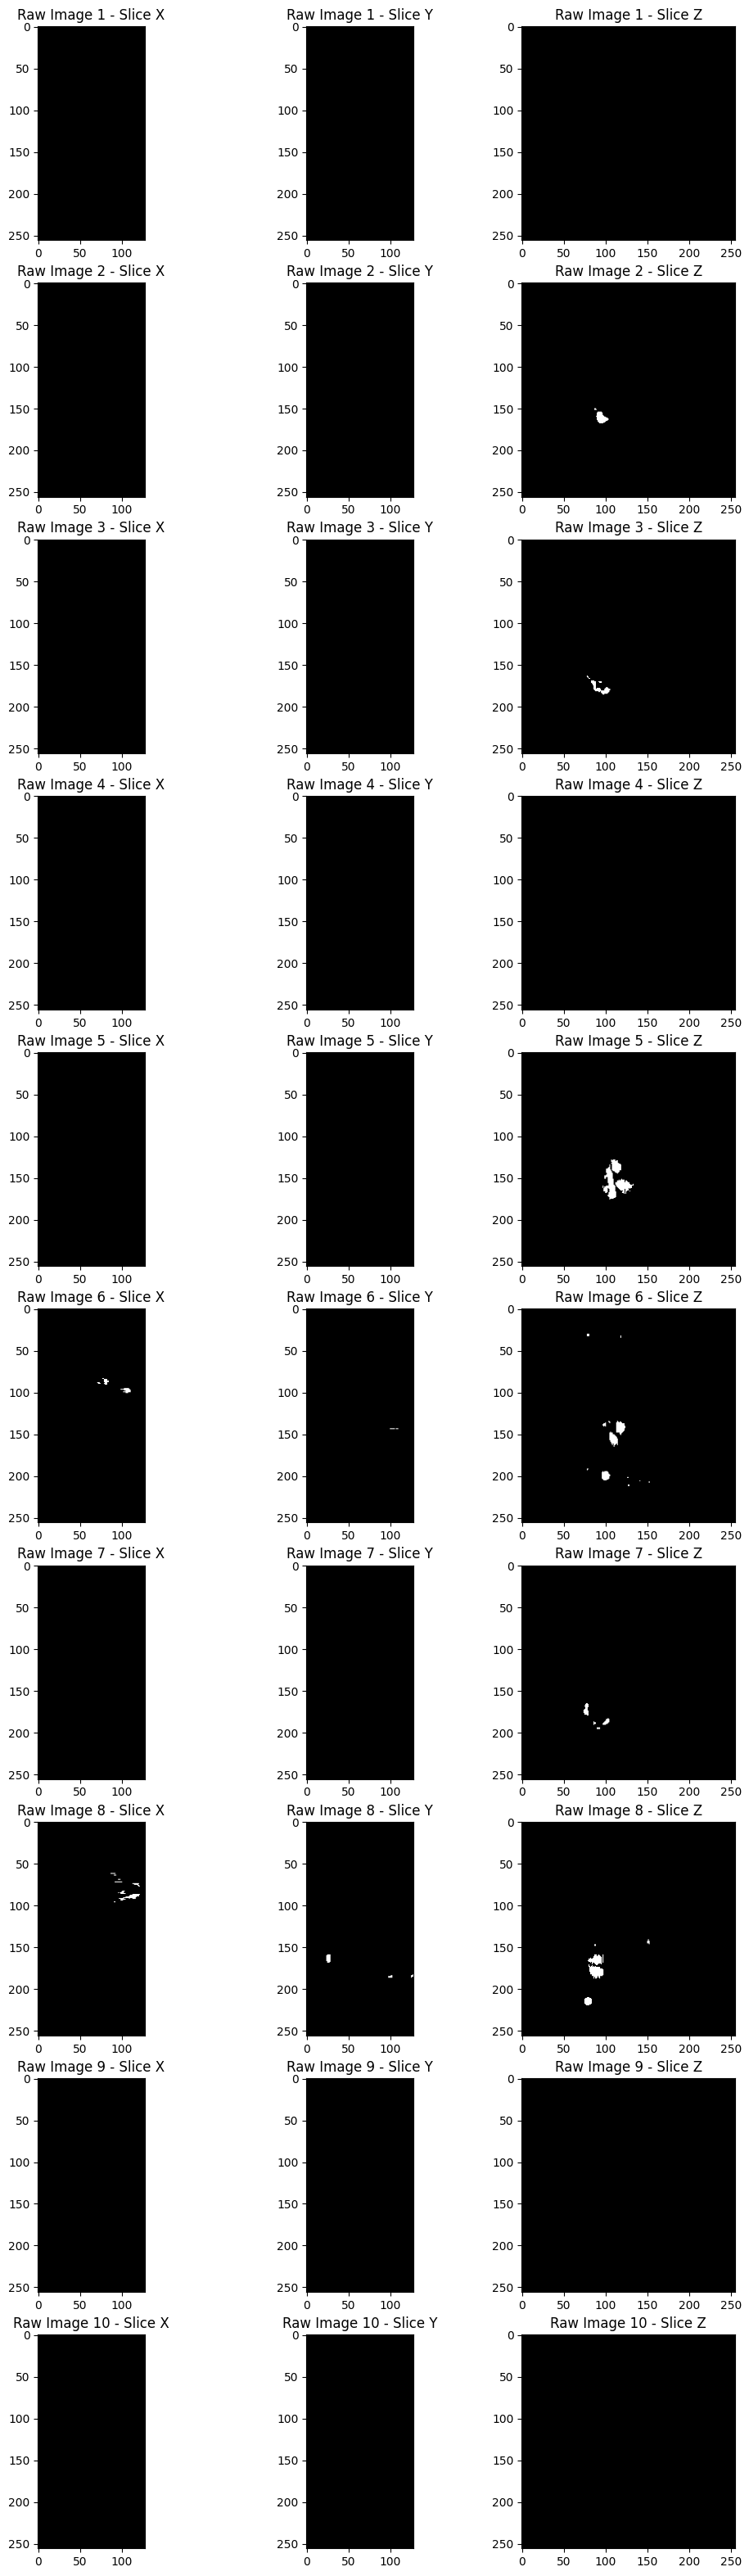

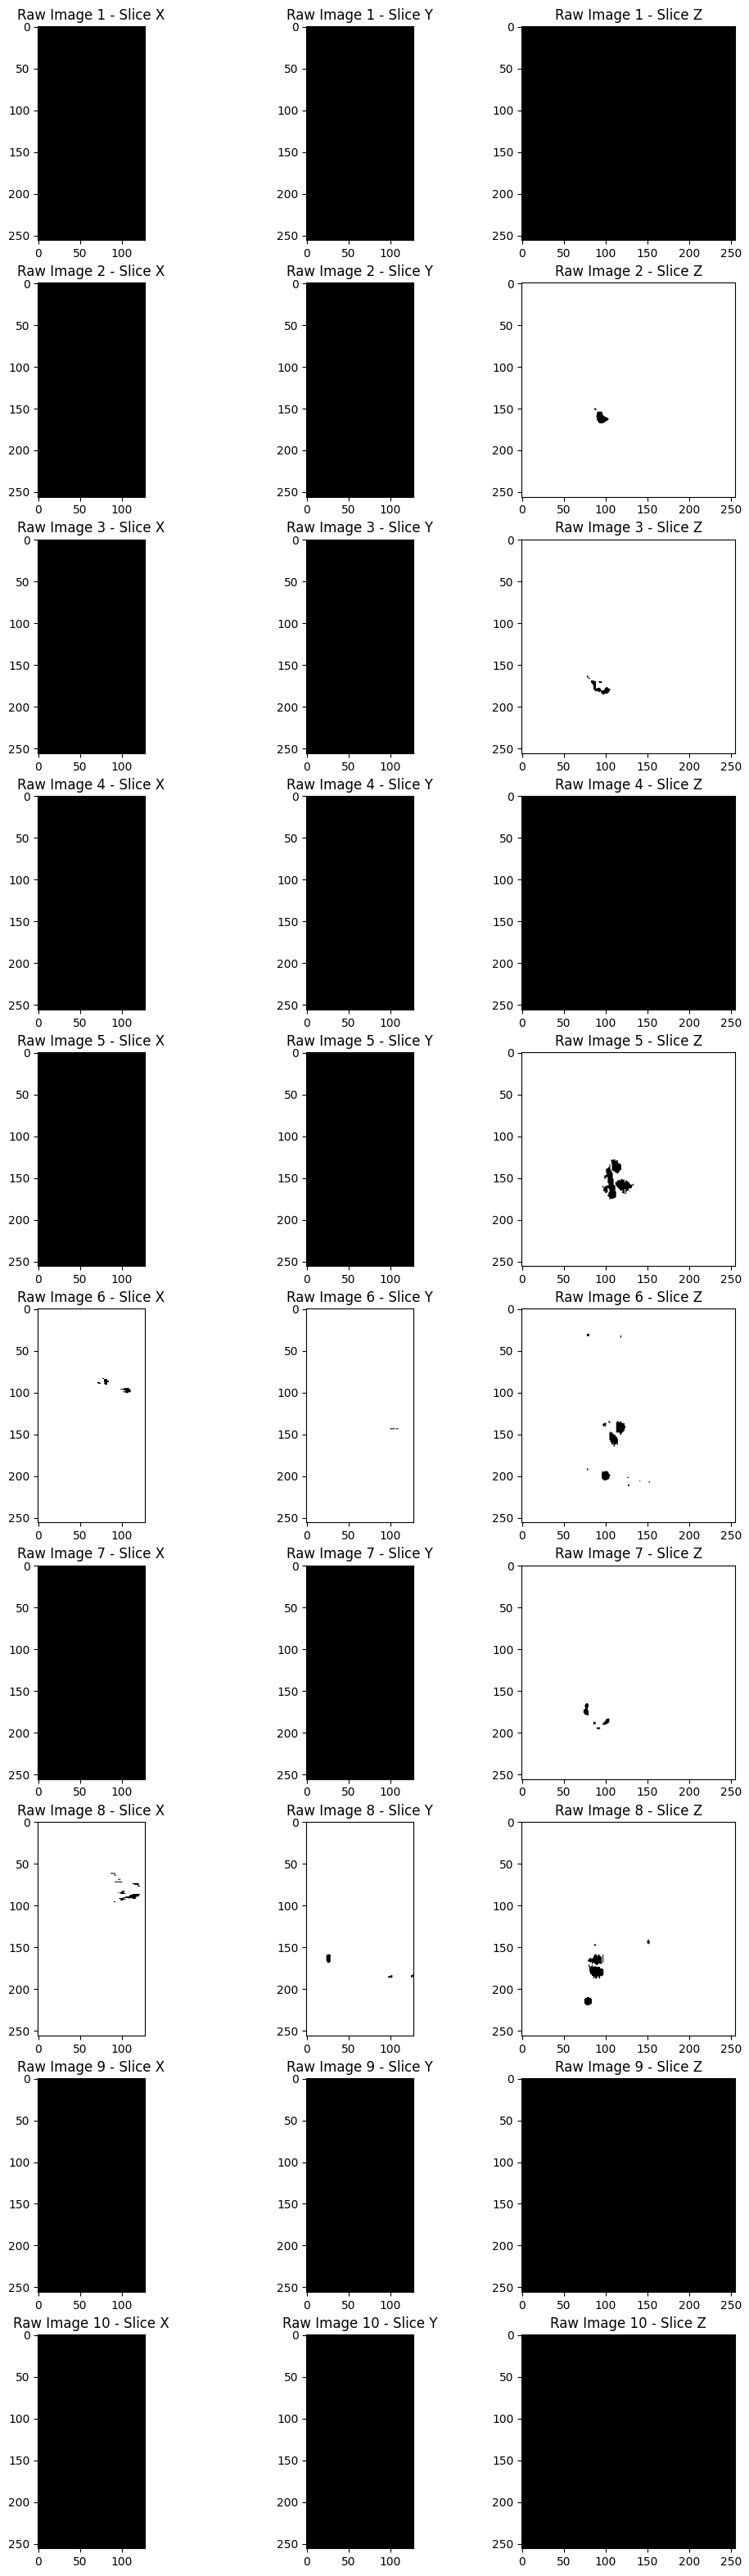

In [25]:
visualize_batch(batch_x, batch_y, slice_=50)

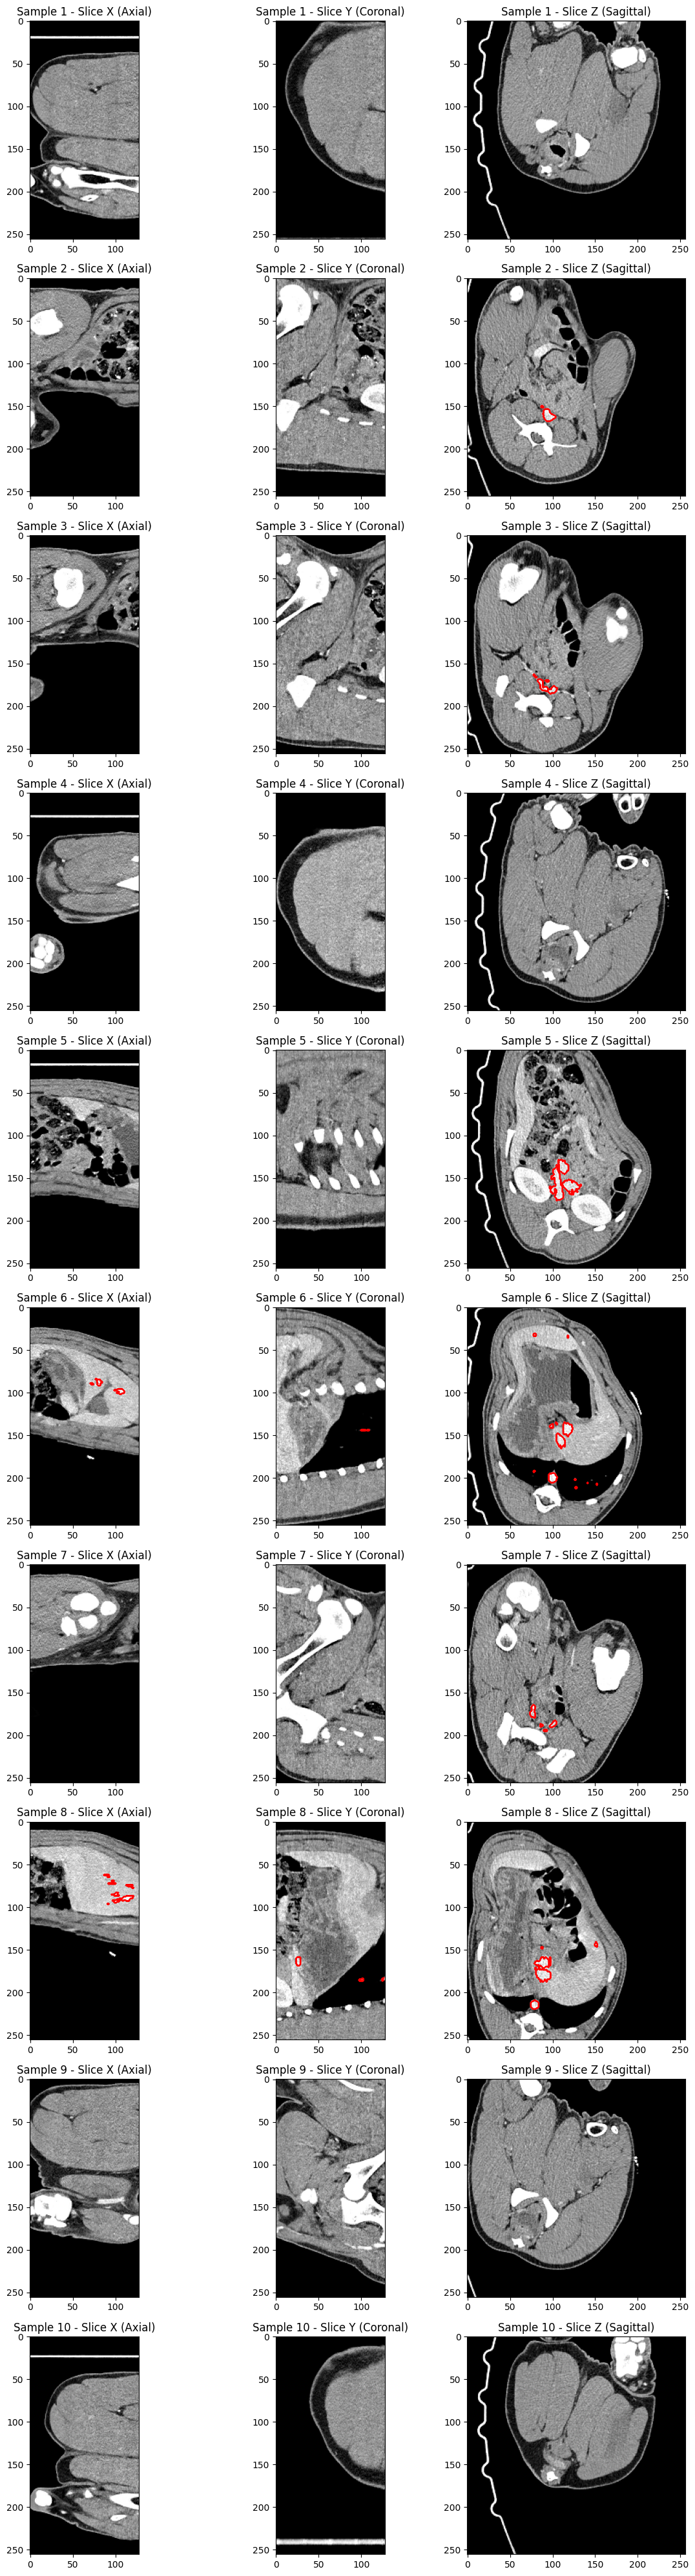

In [16]:
visualize_batch_contur(batch_x, batch_y, slice_x=50, slice_y=50, slice_z=50, alpha=0.5)

# Train UNET_3D

In [131]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Num GPUs Available:  2


In [132]:
from tensorflow.keras import backend as K
from tensorflow.keras import Model, layers, mixed_precision
#from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Activation, Concatenate, BatchNormalization
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Conv3DTranspose, Dropout, Activation, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import HeNormal

In [133]:
# Metrics

# Dice coefficient metric
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.cast(K.flatten(y_true), dtype=K.floatx())
    y_pred_f = K.cast(K.flatten(y_pred), dtype=K.floatx())
    smooth = K.cast(smooth, dtype=K.floatx())
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Additional segmentation metrics
def precision(y_true, y_pred):
    y_pred_bin = K.round(y_pred)
    true_positives = K.sum(y_true * y_pred_bin)
    predicted_positives = K.sum(y_pred_bin)
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    y_pred_bin = K.round(y_pred)
    true_positives = K.sum(y_true * y_pred_bin)
    possible_positives = K.sum(y_true)
    return true_positives / (possible_positives + K.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + K.epsilon())

In [134]:
from tensorflow.keras import backend as K

def dice_coef_loss(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    smooth = K.cast(smooth, dtype=K.floatx())
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - dice


def focal_tversky_loss(y_true, y_pred, alpha=0.3, beta=0.7, gamma=0.75, smooth=1):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    smooth = K.cast(smooth, dtype=K.floatx())
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    TP = K.sum(y_true_f * y_pred_f)
    FP = K.sum((1 - y_true_f) * y_pred_f)
    FN = K.sum(y_true_f * (1 - y_pred_f))
    
    tversky_index = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    return K.pow((1 - tversky_index), gamma)


def tversky_loss(y_true, y_pred, alpha=0.4, beta=0.6, smooth=1):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    smooth = K.cast(smooth, dtype=K.floatx())
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    TP = K.sum(y_true_f * y_pred_f)
    FP = K.sum((1 - y_true_f) * y_pred_f)
    FN = K.sum(y_true_f * (1 - y_pred_f))
    
    return 1 - ((TP + smooth) / (TP + alpha * FP + beta * FN + smooth))


def jaccard_loss(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    smooth = K.cast(smooth, dtype=K.floatx())
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return 1 - ((intersection + smooth) / (union + smooth))


def weighted_binary_crossentropy(y_true, y_pred):
    # Default weights (used if not explicitly set)
    default_weights = [1.0, 1.0]  # Default: equal weight for both classes
    weights = getattr(weighted_binary_crossentropy, "weights", default_weights)

    weight_positive, weight_negative = weights

    # Convert to float tensors
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())

    # Avoid log(0)
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

    # Compute weighted binary crossentropy loss
    loss = - (weight_positive * y_true * K.log(y_pred) + 
              weight_negative * (1 - y_true) * K.log(1 - y_pred))
    
    return K.mean(loss)



In [135]:
def get_3d_unet(shape=(128, 128, 128)):
    """
    Creates a 3D U-Net model.
    
    Parameters:
    - size: The shape of the input data (batch_size, 128, 128, 128, 1).
    
    Returns:
    - model: A 3D U-Net model.
    """
    # Extract input shape from the size parameter (excluding batch size)
    input_shape = (shape[0], shape[1], shape[2], 1)
    
    # Set image data format to 'channels_last'
    tf.keras.backend.set_image_data_format('channels_last')
    
    # Define the inputs
    inputs = layers.Input(shape=input_shape)
    
    # Define kernel initializer
    seed_value = 42  # Set your desired seed value    
    tf.random.set_seed(seed_value) # Set global seed for TensorFlow
    kernel_initializer = HeNormal(seed=seed_value) # Use seeded HeNormal initializer

    # Encoder (Downsampling)
    c = layers.Conv3D(8, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(inputs)
    c = layers.Conv3D(8, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c)
    c = layers.Conv3D(8, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c)
    c = layers.Conv3D(8, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c)
    c = layers.Conv3D(8, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c)
    c = layers.Dropout(0.2)(c)  # Adding Dropout after the convolution block
    p = layers.MaxPooling3D((2, 2, 2))(c)
    
    c0 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(p)
    c0 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c0)
    c0 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c0)
    c0 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c0)
    c0 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c0)
    c0 = layers.Dropout(0.2)(c0)  # Adding Dropout after the convolution block
    p0 = layers.MaxPooling3D((2, 2, 2))(c0)
    
    c1 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(p0)
    c1 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c1)
    c1 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c1)
    c1 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c1)
    c1 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c1)
    c1 = layers.Dropout(0.2)(c1)  # Adding Dropout after the convolution block
    p1 = layers.MaxPooling3D((2, 2, 2))(c1)
    
    c2 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(p1)
    c2 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c2)
    c2 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c2)
    c2 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c2)
    c2 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c2)
    c2 = layers.Dropout(0.2)(c2)  # Adding Dropout after the convolution block
    p2 = layers.MaxPooling3D((2, 2, 2))(c2)
    
    c3 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(p2)
    c3 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c3)
    c3 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c3)
    c3 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c3)
    c3 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c3)
    c3 = layers.Dropout(0.2)(c3)  # Adding Dropout after the convolution block
    p3 = layers.MaxPooling3D((2, 2, 2))(c3)
    
    # Bottleneck
    b1 = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(p3)
    b1 = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(b1)
    b1 = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(b1)
    b1 = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(b1)
    b1 = layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(b1)
    b1 = layers.Dropout(0.3)(b1)  # Adding Dropout after the bottleneck convolution block
    
    # Decoder (Upsampling)
    u1 = layers.Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(b1)
    u1 = layers.concatenate([u1, c3])  # Concatenate with the corresponding encoder layer
    c4 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(u1)
    c4 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c4)
    c4 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c4)
    c4 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c4)
    c4 = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c4)
    c4 = layers.Dropout(0.2)(c4)  # Adding Dropout after the convolution block
    
    u2 = layers.Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c2])  # Concatenate with the corresponding encoder layer
    c5 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(u2)
    c5 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c5)
    c5 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c5)
    c5 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c5)
    c5 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c5)
    c5 = layers.Dropout(0.2)(c5)  # Adding Dropout after the convolution block
    
    u3 = layers.Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u3 = layers.concatenate([u3, c1])  # Concatenate with the corresponding encoder layer
    c6 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(u3)
    c6 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c6)
    c6 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c6)
    c6 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c6)
    c6 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c6)
    c6 = layers.Dropout(0.2)(c6)  # Adding Dropout after the convolution block
    
    u4 = layers.Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u4 = layers.concatenate([u4, c0])  # Concatenate with the corresponding encoder layer
    c7 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(u4)
    c7 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c7)
    c7 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c7)
    c7 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c7)
    c7 = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c7)
    c7 = layers.Dropout(0.2)(c7)  # Adding Dropout after the convolution block
    
    u5 = layers.Conv3DTranspose(8, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u5 = layers.concatenate([u5, c])  # Concatenate with the corresponding encoder layer
    c8 = layers.Conv3D(8, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(u5)
    c8 = layers.Conv3D(8, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c8)
    c8 = layers.Conv3D(8, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c8)
    c8 = layers.Conv3D(8, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c8)
    c8 = layers.Conv3D(8, (3, 3, 3), activation='relu', padding='same', kernel_initializer=kernel_initializer)(c8)
    c8 = layers.Dropout(0.2)(c8)  # Adding Dropout after the convolution block
    
    # Output Layer
    outputs = layers.Conv3D(2, (1, 1, 1), activation='sigmoid')(c8)
    
    # Create the model
    model = Model(inputs, outputs)
    
    return model

## Train

In [136]:
#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('mixed_float16')

In [137]:
import wandb
from wandb.integration.keras import WandbCallback
wandb.login() # 784560b40ab4e2961fe5d43ab8bf11739e40cabf

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [138]:
num_cykles = 200
num_epoch = 10
batch_size = 5

weighted_binary_crossentropy.weights = [5000,10]
shape = (128,128,128) #128^3

task = 'pilsen_pigs' # pilsen_pigs, deepvesselnet, ircad
loss_func = weighted_binary_crossentropy
learning_rate = 0.001

In [139]:
if (task == 'ircad'):
    ct_ids_train = [1,2,3,4,6,7,8,9,11,12,13,14,15,16,18,19,20]
    ct_ids_test = [17,10,5]
    promene = s_liver
    train_generator = image_generator(ct_ids_train, promene, batch_size=batch_size, shape=shape)
    test_generator  = image_generator(ct_ids_test, promene, batch_size=batch_size, shape=shape)
    text = promene[0]
    
elif (task == 'pilsen_pigs'):
    ct_ids_train = ['Tx025D_Art', 'Tx017D_Art', 'Tx019D_Ven', 'Tx038D_Art', 'Tx025D_Ven', 'Tx039D_Art', 'Tx041D_Art', 'Tx023D_Ven', 'Tx031D_Art', 'Tx024D_Art', 'Tx030D_Art', 'Tx037D_Art', 'Tx018D_Art']
    ct_ids_test = ['Tx021D_Ven', 'Tx040D_Art']      
    train_generator = image_generator_pilsen_pigs(ct_ids_train, batch_size=batch_size, shape=shape)
    test_generator  = image_generator_pilsen_pigs(ct_ids_test, batch_size=batch_size, shape=shape)
    text = task
    
elif (task == 'deepvesselnet'):
    directory = "2D_to_3D/data/deepvesselnet/raw"
    all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]    
    ct_ids_train, ct_ids_test = split_files(all_files, train_ratio=0.8)
    train_generator = image_generator_deepvesselnet(ct_ids_train, batch_size=batch_size, shape=shape)
    test_generator  = image_generator_deepvesselnet(ct_ids_test, batch_size=batch_size, shape=shape)
    text = task
    
else: print("Nebyla zadana uloha")

# Calculate steps per epoch
train_steps = (len(ct_ids_train) * batch_size) // batch_size
test_steps = (len(ct_ids_test) * batch_size) // batch_size

print("ct_ids_train: ", ct_ids_train)
print()
print("ct_ids_test: ", ct_ids_test)
print()

ct_ids_train:  ['Tx025D_Art', 'Tx017D_Art', 'Tx019D_Ven', 'Tx038D_Art', 'Tx025D_Ven', 'Tx039D_Art', 'Tx041D_Art', 'Tx023D_Ven', 'Tx031D_Art', 'Tx024D_Art', 'Tx030D_Art', 'Tx037D_Art', 'Tx018D_Art']

ct_ids_test:  ['Tx021D_Ven', 'Tx040D_Art']



In [141]:
text_to_save = text + '_simple_small_'
# text_to_save = 'pisen_pigs_simple_small'
print("text_to_save: \t" + text_to_save)

project_text = '3D_UNET_final'
print("project_text: \t" + project_text)

# Initialize W&B
wandb_log = project_text+"/"+text_to_save+".txt"
print("wandb_log: \t" + wandb_log)

text_to_save: 	pilsen_pigs_simple_small_
project_text: 	3D_UNET_final
wandb_log: 	3D_UNET_final/pilsen_pigs_simple_small_.txt


In [142]:
'''x, y = next(test_generator)
print(x.shape, y.shape)
plt.subplot(121), plt.imshow(x[0,30,:,:,0], cmap='gray')
plt.subplot(122), plt.imshow(y[0,30,:,:,0], cmap='gray'), plt.show()'''

"x, y = next(test_generator)\nprint(x.shape, y.shape)\nplt.subplot(121), plt.imshow(x[0,30,:,:,0], cmap='gray')\nplt.subplot(122), plt.imshow(y[0,30,:,:,0], cmap='gray'), plt.show()"

### New model

In [143]:
# Create and compile the model inside strategy's scope

with strategy.scope():
    model = get_3d_unet(shape=shape)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-7),  # SGD(), tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-7)
        loss=loss_func,
        metrics=[
            tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1], name="iou_foreground"),
            tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0], name="iou_background"),
            dice_coef,
            tf.keras.metrics.BinaryAccuracy(name="accuracy"),
            precision,
            recall,
            f1_score
        ]
    )
    #lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

wandb.init(
    project=project_text,
    name=text_to_save,
    config={
        "experiment_name": text_to_save,
        "input_size":shape,
        "ct_ids_train": ct_ids_train,
        "ct_ids_test": ct_ids_test,
        "batch_size": batch_size,
        "epochs": num_epoch,
        "num_cykles": num_cykles,
        "class_weights": weighted_binary_crossentropy.weights,
        "learning_rate": learning_rate,
        "model_architecture": "3D U-Net",
        "optimizer": "Adam",
        "loss_function": loss_func,
        "metrics": ["IoU_background", "IoU_foreground", "DiceCoef", "Accuracy", "Precision", "Recall", "F1-score"]
    }
)

# Uložit run ID do souboru pro budoucí použití
os.makedirs(os.path.dirname(wandb_log), exist_ok=True) # Make directory if does not exists
with open(wandb_log, "w") as f:
    f.write(wandb.run.id)

### re-Train

In [70]:
model_name = project_text+"/"+text_to_save+"_cycle_24.h5"

with strategy.scope():
    # Define custom objects
    custom_objects = {
        "dice_coef": dice_coef,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "weighted_binary_crossentropy": weighted_binary_crossentropy
    }
    # Load the model with custom objects
    model = tf.keras.models.load_model(model_name, custom_objects=custom_objects)
print("model_name: ", model_name)

# Retrain
with open(wandb_log, "r") as f:
    run_id = f.read().strip()
print("run_id: ",run_id)
#run_id = "cs48nwd0"
    
wandb.init(
    project=project_text,
    name=text_to_save,
    id=run_id,  # Použití stejného ID
    resume="must",  # W&B musí pokračovat v běhu
    config={
        "experiment_name": text_to_save,
        "input_size":shape,
        "ct_ids_train": ct_ids_train,
        "ct_ids_test": ct_ids_test,
        "batch_size": batch_size,
        "epochs": num_epoch,
        "num_cykles": num_cykles,
        "class_weights": weighted_binary_crossentropy.weights,
        "learning_rate": learning_rate,
        "model_architecture": "3D U-Net",
        "optimizer": "Adam",
        "loss_function": loss_func,
        "metrics": ["IoU_background", "IoU_foreground", "DiceCoef", "Accuracy", "Precision", "Recall", "F1-score"]
    }
)

model_name:  3D_UNET_final/pisen_pigs_simple_small_cycle_24.h5
run_id:  rb3uv117


### Fit

In [ ]:
for i in range(0,num_cykles):
    print(f"\n--- Training cycle {i}/{num_cykles} ---\n")

    # Trénování modelu s W&B callbackem
    history = model.fit(
        train_generator,
        epochs=num_epoch,
        steps_per_epoch=train_steps,
        validation_data=test_generator,
        validation_steps=test_steps,
        verbose=1,
        callbacks=[
            WandbCallback(
                save_model=False,  # Nebo True, pokud chceš ukládat model do W&B
                log_weights=True,
                log_gradients=False,  # True, pokud tě zajímají i gradienty
                log_evaluation=True   # Vyhodnocení val datasetu
            )
        ]
    )

    # Uložení modelu lokálně
    model.save(f"{project_text}/{text_to_save}_cycle_{i}.h5")

# Ukončení runu
wandb.finish()

In [ ]:
print(text_to_save)
print(i)

# Vyhodnoceni

In [71]:
import pandas as pd

In [52]:
# NLoad saved model

with strategy.scope():
    # Define custom objects
    custom_objects = {
        "dice_coef": dice_coef,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "weighted_binary_crossentropy": weighted_binary_crossentropy
    }
    # Load the model with custom objects
    #model = tf.keras.models.load_model(project_text+"/"+text_to_save+"_processor.h5", custom_objects=custom_objects)
    model = tf.keras.models.load_model("3D_UNET_final/pisen_pigs_simple_small_cycle_24.h5", custom_objects=custom_objects)

In [53]:
# Prepare image generators

task = 'pisen_pigs' # pisen_pigs, deepvesselnet, ircad
batch_size=5
shape=(128, 128, 128)

if (task == 'ircad'):
    ct_ids_train = [1,2,3,4,6,7,8,9,11,12,13,14,15,16,18,19,20]
    ct_ids_test = [17,10,5]
    promene = s_liver
    train_generator = image_generator(ct_ids_train, promene, batch_size=batch_size, shape=shape)
    test_generator  = image_generator(ct_ids_test, promene, batch_size=batch_size, shape=shape)
    
elif (task == 'pisen_pigs'):
    ct_ids_train = ['Tx025D_Ven', 'Tx017D_Art', 'Tx023D_Ven', 'Tx019D_Ven', 'Tx025D_Art', 'Tx018D_Art']
    ct_ids_test = ['Tx021D_Ven', 'Tx024D_Art']    
    train_generator = image_generator_pilsen_pigs(ct_ids_train, batch_size=batch_size, shape=shape)
    test_generator  = image_generator_pilsen_pigs(ct_ids_test, batch_size=batch_size, shape=shape)
    
elif (task == 'deepvesselnet'):
    directory = "2D_to_3D/data/deepvesselnet/raw"
    all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]    
    ct_ids_train, ct_ids_test = split_files(all_files, train_ratio=0.8)
    train_generator = image_generator_deepvesselnet(ct_ids_train, batch_size=batch_size, shape=shape)
    test_generator  = image_generator_deepvesselnet(ct_ids_test, batch_size=batch_size, shape=shape)
    
else: print("Nebyla zadana uloha")

# Calculate steps per epoch
train_steps = (len(ct_ids_train) * batch_size) // batch_size
test_steps = (len(ct_ids_test) * batch_size) // batch_size

print("ct_ids_train: ", ct_ids_train)
print()
print("ct_ids_test: ", ct_ids_test)

ct_ids_train:  ['Tx025D_Ven', 'Tx017D_Art', 'Tx023D_Ven', 'Tx019D_Ven', 'Tx025D_Art', 'Tx018D_Art']

ct_ids_test:  ['Tx021D_Ven', 'Tx024D_Art']


In [124]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 128, 1)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 128, 128, 128, 8)     224       ['input_1[0][0]']             
                                                                                                  
 conv3d_1 (Conv3D)           (None, 128, 128, 128, 8)     1736      ['conv3d[0][0]']              
                                                                                                  
 conv3d_2 (Conv3D)           (None, 128, 128, 128, 8)     1736      ['conv3d_1[0][0]']            
                                                                                              

In [76]:
# Evaluate the model
results_dict = {}
evaluation = model.evaluate(
    test_generator,
    steps=test_steps,  
    verbose=1  
)
# Get metric names from the model
metric_names = model.metrics_names  # e.g., ['loss', 'iou_background', ...]

# Collect results for each metric
for m, v in zip(metric_names, evaluation):
    if m not in results_dict:
        results_dict[m] = {}
    results_dict[m][text] = v

W0000 00:00:1746198137.082539  491898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746198137.087468  491903 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746198137.161557  491898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746198137.161697  491898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746198137.163568  491898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746198137.165865  491898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746198137.166046  491898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746198137.166229  491898 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746198137.173429  491898 gp

1/2 [==============>...............] - ETA: 0s - loss: 74.2816 - iou_foreground: 0.9832 - iou_background: 0.9829 - dice_coef: 0.9914 - accuracy: 0.9915 - precision: 0.9848 - recall: 0.9981 - f1_score: 0.9914

W0000 00:00:1746198200.591668  491900 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746198200.676859  491901 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746198200.698895  491900 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746198200.699260  491900 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746198200.702034  491900 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746198200.711887  491900 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746198200.712640  491900 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746198200.713416  491900 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746198200.733160  491900 gp

2/2 [==============================] - 64s 64s/step - loss: 54.1716 - iou_foreground: 0.9842 - iou_background: 0.9839 - dice_coef: 0.9919 - accuracy: 0.9920 - precision: 0.9853 - recall: 0.9985 - f1_score: 0.9919


In [77]:
# Create a DataFrame with metrics as rows and model names as columns
metrics_df = pd.DataFrame(results_dict).transpose()
print("Summary of all metrics:")
print(metrics_df)

Summary of all metrics:
                pilsen_pigs
loss              54.171608
iou_foreground     0.984160
iou_background     0.983947
dice_coef          0.991865
accuracy           0.991963
precision          0.985287
recall             0.998531
f1_score           0.991865


In [88]:
x, y = next(test_generator)
prediction = model.predict(
    x,  # Input data
    verbose=1
)
print(x.shape)
print(y.shape)
print(prediction.shape)

W0000 00:00:1746205170.062411  491902 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746205170.202362  491902 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746205170.205266  491902 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1746205170.208019  491902 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


1/1 [==============================] - 1s 579ms/step
(5, 128, 128, 128, 1)
(5, 128, 128, 128, 2)
(5, 128, 128, 128, 2)


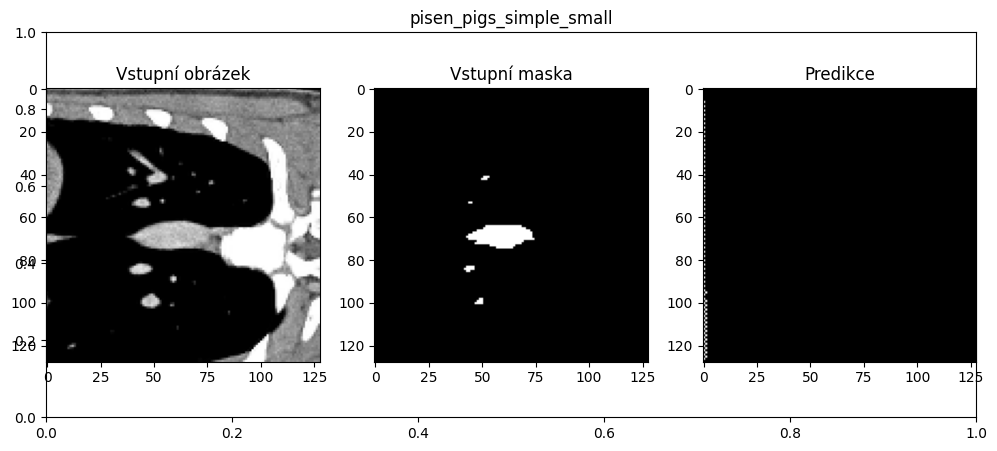

(<matplotlib.image.AxesImage at 0x154500d830e0>,
 Text(0.5, 1.0, 'Predikce'),
 None)

In [104]:
image =  4
vrstva = 50

plt.figure(figsize=(12, 5))
plt.title(text_to_save)
plt.subplot(131).imshow(x[image, vrstva,:,:,0], cmap='gray'), plt.title("Vstupní obrázek")
plt.subplot(132).imshow(y[image, vrstva,:,:,0], cmap='gray'), plt.title("Vstupní maska")
plt.subplot(133).imshow(prediction_[image, vrstva,:,:,0], cmap='gray'), plt.title("Predikce"), plt.show()

In [87]:
prediction_ = (prediction > 0.7).astype(np.float32)

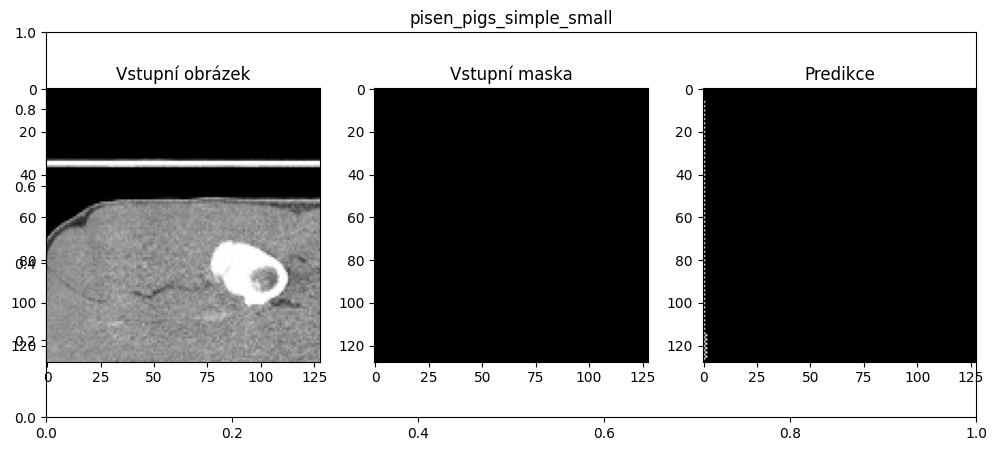

(<matplotlib.image.AxesImage at 0x14e01edadac0>,
 Text(0.5, 1.0, 'Predikce'),
 None)

In [63]:
image = 0
vrstva = 100

plt.figure(figsize=(12, 5))
plt.title(text_to_save)
plt.subplot(131).imshow(x[image, vrstva,:,:,0], cmap='gray'), plt.title("Vstupní obrázek")
plt.subplot(132).imshow(y[image, vrstva,:,:,0], cmap='gray'), plt.title("Vstupní maska")
plt.subplot(133).imshow(prediction_[image, vrstva,:,:,0], cmap='gray'), plt.title("Predikce"), plt.show()

# Konkrétní snímek

In [130]:
import nibabel as nib
import numpy as np
from tensorflow.keras.models import Model
from tqdm import tqdm

def resample_to_voxelsize(volume, spacing, target_spacing=(1.0, 1.0, 1.0), order=3):
    """Resample volume to target voxel spacing using scipy zoom"""
    from scipy.ndimage import zoom
    resize_factors = np.array(spacing) / np.array(target_spacing)
    return zoom(volume, resize_factors, order=order)

def sliding_window_inference(nifti_path, model: Model, window_shape=(256, 256, 64), stride=(128, 128, 32)):
    """
    Apply a trained 3D model using sliding window inference on a NIfTI volume after preprocessing.

    Parameters:
        nifti_path (str): path to the CT scan (file name).
        model (Model): Trained Keras model.
        window_shape (tuple): Shape of the sliding window.
        stride (tuple): Step size of sliding window.
    
    Returns:
        output_volume (np.ndarray): Prediction mask for the entire volume.
    """
    nifti_path = Path(nifti_path)
    
    # === 1. Load NIfTI file ===
    raw_nii = nib.load(nifti_path)
    raw = raw_nii.get_fdata()
    spacing = raw_nii.header.get_zooms()[:3]  # (z, y, x)

    mask_nii = nib.load(nifti_path.parent / 'artery.nii.gz')
    mask = mask_nii.get_fdata()
    mask = (mask > 0.5).astype(np.float32)

    # === 2. Apply windowing (CT intensity range) ===
    raw = window(raw, center=40, width=400)

    # === 3. Resample to isotropic voxels ===
    raw = resample_to_voxelsize(raw, spacing, target_spacing=(1.0, 1.0, 1.0), order=3)
    mask = resample_to_voxelsize(mask, spacing, target_spacing=(1.0, 1.0, 1.0), order=0)
    
    # === 4. Normalize and expand to 3 channels ===
    raw = (raw - np.min(raw)) / (np.max(raw) - np.min(raw) + 1e-5)
    raw = np.stack([raw] * 1, axis=-1)  # From (Z, Y, X) to (Z, Y, X, 3)
    
    background = 1.0 - mask
    mask = np.stack([mask, background], axis=-1)

    original_shape = raw.shape[:-1]

    # === 5. Padding ===
    pad_width = [
        (0, max(0, window_shape[0] - original_shape[0] % stride[0])),
        (0, max(0, window_shape[1] - original_shape[1] % stride[1])),
        (0, max(0, window_shape[2] - original_shape[2] % stride[2])),
        (0, 0)
    ]
    volume_padded = np.pad(raw, pad_width, mode='constant')
    padded_shape = volume_padded.shape

    output = np.zeros(padded_shape[:-1], dtype=np.float32)
    count_map = np.zeros(padded_shape[:-1], dtype=np.float32)

    # === 6. Sliding window inference ===
    for z in tqdm(range(0, padded_shape[0] - window_shape[0] + 1, stride[0])):
        for y in range(0, padded_shape[1] - window_shape[1] + 1, stride[1]):
            for x in range(0, padded_shape[2] - window_shape[2] + 1, stride[2]):
                patch = volume_padded[z:z+window_shape[0],
                                      y:y+window_shape[1],
                                      x:x+window_shape[2], :]
                
                patch_input = np.expand_dims(patch, axis=0)  # Batch dim
                prediction = model.predict(patch_input, verbose=0)[0]

                output[z:z+window_shape[0],
                       y:y+window_shape[1],
                       x:x+window_shape[2]] += prediction[..., 0]
                count_map[z:z+window_shape[0],
                          y:y+window_shape[1],
                          x:x+window_shape[2]] += 1

    output /= np.maximum(count_map, 1e-5)
    output = output[:original_shape[0], :original_shape[1], :original_shape[2]]

    return raw, mask, output


In [125]:
# NLoad saved model
with strategy.scope():
    # Define custom objects
    custom_objects = {
        "dice_coef": dice_coef,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "weighted_binary_crossentropy": weighted_binary_crossentropy
    }
    # Load the model with custom objects
    #model = tf.keras.models.load_model(project_text+"/"+text_to_save+"_processor.h5", custom_objects=custom_objects)
    loaded_model = tf.keras.models.load_model("3D_UNET_final/pisen_pigs_simple_small_cycle_24.h5", custom_objects=custom_objects)

In [126]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 128, 1)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 128, 128, 128, 8)     224       ['input_1[0][0]']             
                                                                                                  
 conv3d_1 (Conv3D)           (None, 128, 128, 128, 8)     1736      ['conv3d[0][0]']              
                                                                                                  
 conv3d_2 (Conv3D)           (None, 128, 128, 128, 8)     1736      ['conv3d_1[0][0]']            
                                                                                              

In [127]:
raw, mask, output = sliding_window_inference(
    nifti_path="2D_to_3D/data/pilsen_pigs/Tx023D_Ven/Tx023D_Ven.nii.gz",
    model=loaded_model,
    window_shape=(128, 128, 128),
    stride=(64, 64, 64)
)

  0%|          | 0/6 [00:00<?, ?it/s]

(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 1

 17%|█▋        | 1/6 [00:28<02:22, 28.54s/it]

(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 1

 33%|███▎      | 2/6 [00:54<01:49, 27.29s/it]

(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 1

 50%|█████     | 3/6 [01:20<01:19, 26.38s/it]

(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 1

 67%|██████▋   | 4/6 [01:45<00:52, 26.12s/it]

(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 1

 83%|████████▎ | 5/6 [02:10<00:25, 25.56s/it]

(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 128, 128, 1)
(1, 128, 1

100%|██████████| 6/6 [02:35<00:00, 26.00s/it]


In [128]:
print("raw: ", raw.shape)
print("mask: ", mask.shape)
print("output: ", output.shape)

raw:  (358, 358, 599, 1)
mask:  (358, 358, 599, 2)
output:  (358, 358, 599)


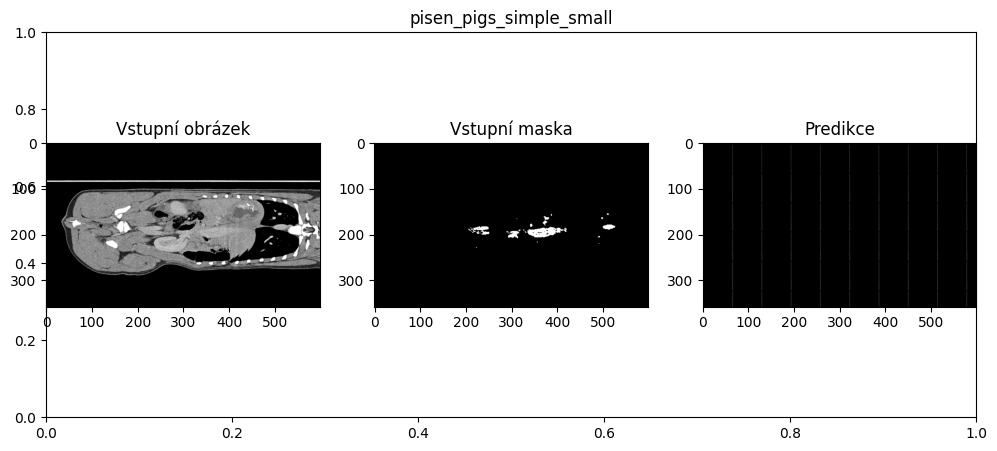

(<matplotlib.image.AxesImage at 0x15450086c1a0>,
 Text(0.5, 1.0, 'Predikce'),
 None)

In [129]:
vrstva = 220

plt.figure(figsize=(12, 5))
plt.title(text_to_save)
plt.subplot(131).imshow(raw[vrstva,:,:,0], cmap='gray'), plt.title("Vstupní obrázek")
plt.subplot(132).imshow(mask[vrstva,:,:,0], cmap='gray'), plt.title("Vstupní maska")
plt.subplot(133).imshow(output[vrstva,:,:], cmap='gray'), plt.title("Predikce"), plt.show()

In [75]:
output_ = (output > 0.2).astype(np.float32)

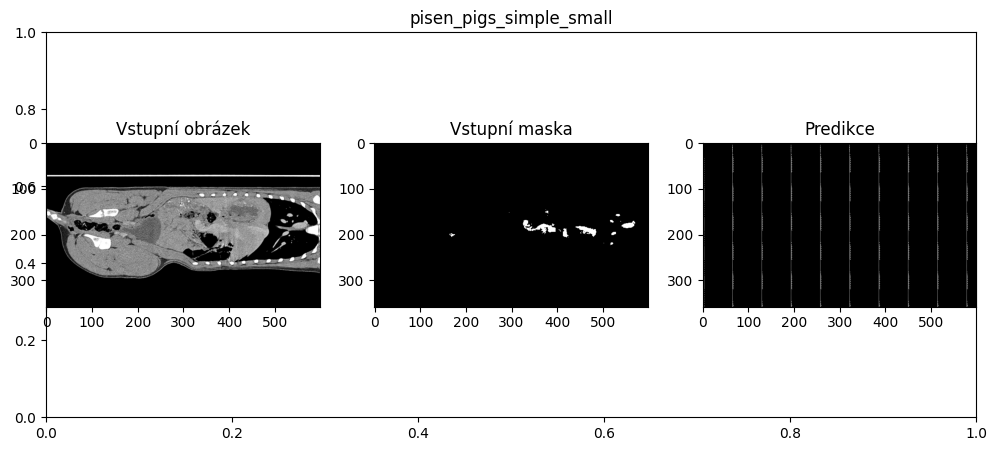

(<matplotlib.image.AxesImage at 0x14e01cbc6ae0>,
 Text(0.5, 1.0, 'Predikce'),
 None)

In [76]:
vrstva = 200

plt.figure(figsize=(12, 5))
plt.title(text_to_save)
plt.subplot(131).imshow(raw[vrstva,:,:,0], cmap='gray'), plt.title("Vstupní obrázek")
plt.subplot(132).imshow(mask[vrstva,:,:,0], cmap='gray'), plt.title("Vstupní maska")
plt.subplot(133).imshow(output_[vrstva,:,:], cmap='gray'), plt.title("Predikce"), plt.show()

In [221]:
output_dir = Path('predikce')
os.makedirs(os.path.dirname(output_dir), exist_ok=True) # Make directory if does not exists
    
# If you have an affine from the original scan, use it. Otherwise use identity
affine = np.eye(4)

# Create and save NIfTI files
nib.save(nib.Nifti1Image(raw[...,0], affine), output_dir/'raw.nii.gz')
nib.save(nib.Nifti1Image(mask[...,0], affine), output_dir/'mask.nii.gz')
nib.save(nib.Nifti1Image(output_, affine), output_dir/'output.nii.gz')

print("NIfTI files saved successfully.")

NIfTI files saved successfully.


In [222]:
import zipfile
#import shutil

# Create ZIP file of the output directory
zip_path = output_dir.with_suffix('.zip')
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in output_dir.glob('*'):
        zipf.write(file, arcname=file.name)

print(f"Directory zipped successfully at: {zip_path}")

Directory zipped successfully at: 2D_to_3D/predikce.zip
